
# Train GRU Model from WavLM features and discrete labels

### For GTzan dataset - 3CV

##### https://github.com/microsoft/unilm/tree/master/wavlm
##### https://github.com/audeering/w2v2-how-to/blob/main/notebook.ipynb

In [1]:
import pandas as pd
import numpy as np
import os

### Process Feature Files

In [2]:
!pwd

/home/etsmtl/akoerich/DEV/Music


In [3]:
# Path to feature files
path_features = 'features'
extension     = 'wavlmlargefeat'

all_files = [file for file in os.listdir(path_features) if file.endswith(extension)]

sorted_all_files = sorted(all_files)
sorted_all_files

['blues.00000.wavlmlargefeat',
 'blues.00001.wavlmlargefeat',
 'blues.00002.wavlmlargefeat',
 'blues.00003.wavlmlargefeat',
 'blues.00004.wavlmlargefeat',
 'blues.00005.wavlmlargefeat',
 'blues.00006.wavlmlargefeat',
 'blues.00007.wavlmlargefeat',
 'blues.00008.wavlmlargefeat',
 'blues.00009.wavlmlargefeat',
 'blues.00010.wavlmlargefeat',
 'blues.00011.wavlmlargefeat',
 'blues.00012.wavlmlargefeat',
 'blues.00013.wavlmlargefeat',
 'blues.00014.wavlmlargefeat',
 'blues.00015.wavlmlargefeat',
 'blues.00016.wavlmlargefeat',
 'blues.00017.wavlmlargefeat',
 'blues.00018.wavlmlargefeat',
 'blues.00019.wavlmlargefeat',
 'blues.00020.wavlmlargefeat',
 'blues.00021.wavlmlargefeat',
 'blues.00022.wavlmlargefeat',
 'blues.00023.wavlmlargefeat',
 'blues.00024.wavlmlargefeat',
 'blues.00025.wavlmlargefeat',
 'blues.00026.wavlmlargefeat',
 'blues.00027.wavlmlargefeat',
 'blues.00028.wavlmlargefeat',
 'blues.00029.wavlmlargefeat',
 'blues.00030.wavlmlargefeat',
 'blues.00031.wavlmlargefeat',
 'blues.

### Create a stratified 3-fold holdout with shuffled 334, 333, and 333 samples

In [4]:
import random
from sklearn.model_selection import train_test_split

# Assume you have a list of filenames from the GTzan dataset
# Replace 'filenames' with your actual list of filenames
filenames = sorted_all_files

# Shuffle the filenames
random.shuffle(filenames)

# Extract genre labels from filenames
genres = [filename.split('.')[0] for filename in filenames]

# Split the filenames and genre labels into train and test sets
# We'll create 3 folds with approximately 340, 330, and 330 samples each
# Stratify based on genres to ensure each fold has proportional representation of genres
fold1_gtzan, remaining_filenames, fold1_genres, remaining_genres = train_test_split(
    filenames, genres, train_size=334, stratify=genres, random_state=42
)

# Remaining filenames and genres after fold 1
# Since we have 1000 - 340 = 660 remaining samples, we split them into two folds of 330 each
fold2_gtzan, fold3_gtzan, fold2_genres, fold3_genres = train_test_split(
    remaining_filenames, remaining_genres, train_size=333, stratify=remaining_genres, random_state=42
)

# Now fold1_filenames, fold2_filenames, fold3_filenames contain the filenames for each fold
# Similarly, fold1_genres, fold2_genres, fold3_genres contain the corresponding genres

# Example usage:
print("Fold 1:", len(fold1_gtzan), fold1_gtzan[:5], fold1_genres[:5])
print("Fold 2:", len(fold2_gtzan),fold2_gtzan[:5], fold2_genres[:5])
print("Fold 3:", len(fold3_gtzan),fold3_gtzan[:5], fold3_genres[:5])


Fold 1: 334 ['blues.00017.wavlmlargefeat', 'disco.00035.wavlmlargefeat', 'reggae.00053.wavlmlargefeat', 'metal.00048.wavlmlargefeat', 'hiphop.00042.wavlmlargefeat'] ['blues', 'disco', 'reggae', 'metal', 'hiphop']
Fold 2: 333 ['reggae.00089.wavlmlargefeat', 'jazz.00068.wavlmlargefeat', 'metal.00080.wavlmlargefeat', 'rock.00084.wavlmlargefeat', 'metal.00040.wavlmlargefeat'] ['reggae', 'jazz', 'metal', 'rock', 'metal']
Fold 3: 333 ['blues.00011.wavlmlargefeat', 'jazz.00039.wavlmlargefeat', 'pop.00039.wavlmlargefeat', 'country.00044.wavlmlargefeat', 'hiphop.00022.wavlmlargefeat'] ['blues', 'jazz', 'pop', 'country', 'hiphop']


### All feature vectors into a single dataframe

In [5]:
# GTzan fold1
dfs = []
for file in fold1_gtzan:
    df = pd.read_csv(os.path.join(path_features, file))
    dfs.append(df)

df_fold1_gtzan = pd.concat(dfs, ignore_index=True)
# Drop first index column (unamed 0)
df_fold1_gtzan.drop(df_fold1_gtzan.columns[[0]], axis=1, inplace=True)

# GTzan fold2
dfs = []
for file in fold2_gtzan:
    df = pd.read_csv(os.path.join(path_features, file))
    dfs.append(df)

df_fold2_gtzan = pd.concat(dfs, ignore_index=True)
# Drop first index column (unamed 0)
df_fold2_gtzan.drop(df_fold2_gtzan.columns[[0]], axis=1, inplace=True)

# GTzan fold3
dfs = []
for file in fold3_gtzan:
    df = pd.read_csv(os.path.join(path_features, file))
    dfs.append(df)

df_fold3_gtzan = pd.concat(dfs, ignore_index=True)
# Drop first index column (unamed 0)
df_fold3_gtzan.drop(df_fold3_gtzan.columns[[0]], axis=1, inplace=True)

In [6]:
df_fold1_gtzan.shape, df_fold2_gtzan.shape, df_fold3_gtzan.shape 

((501107, 1024), (499672, 1024), (499656, 1024))

### Process label files

In [7]:
# Path to the GTzan dataset
gtzan_path_features = "features"

# Dictionary to map genre names to numeric labels
genre_label_map = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}

#####################################################################################################
# GTzan Fold1
# Initialize an empty list to store data
data_list = []
# Iterate through the files
for filename in fold1_gtzan:
    genre_path = os.path.join(gtzan_path_features, filename)
    # print(genre_path)
    # Extract genre, track number, and extension from filename
    genre_track, extension = os.path.splitext(filename)
    # Split the genre_track into genre and track number
    genre, track_number = genre_track.split('.')
    # Count number of lines in the corresponding feature file
    feature_filename = f"{genre}.{track_number}.wavlmlargefeat"
    # feature_filepath = os.path.join(genre_path, feature_filename)
    feature_filepath = os.path.join(gtzan_path_features, feature_filename)
    if os.path.exists(feature_filepath):
        with open(feature_filepath, 'r') as f:
            num_lines = sum(1 for line in f)
            num_lines = num_lines - 1
        # Append a dictionary to the list replicated by the number of lines
        for _ in range(num_lines):
            data_list.append({
                "genre": genre,
                "track_number": int(track_number),
                "label": genre_label_map[genre]
            })
# Create a DataFrame from the list of dictionaries
df_fold1_lab = pd.DataFrame(data_list)
# Print first few rows of the DataFrame
print(df_fold1_lab.head())

#####################################################################################################
# GTzan Fold2
# Initialize an empty list to store data
data_list = []
# Iterate through the files
for filename in fold2_gtzan:
    genre_path = os.path.join(gtzan_path_features, filename)
    # print(genre_path)
    # Extract genre, track number, and extension from filename
    genre_track, extension = os.path.splitext(filename)
    # Split the genre_track into genre and track number
    genre, track_number = genre_track.split('.')
    # Count number of lines in the corresponding feature file
    feature_filename = f"{genre}.{track_number}.wavlmlargefeat"
    # feature_filepath = os.path.join(genre_path, feature_filename)
    feature_filepath = os.path.join(gtzan_path_features, feature_filename)
    if os.path.exists(feature_filepath):
        with open(feature_filepath, 'r') as f:
            num_lines = sum(1 for line in f)
            num_lines = num_lines - 1
        # Append a dictionary to the list replicated by the number of lines
        for _ in range(num_lines):
            data_list.append({
                "genre": genre,
                "track_number": int(track_number),
                "label": genre_label_map[genre]
            })
# Create a DataFrame from the list of dictionaries
df_fold2_lab = pd.DataFrame(data_list)
# Print first few rows of the DataFrame
print(df_fold2_lab.head())

#####################################################################################################
# GTzan Fold3
# Initialize an empty list to store data
data_list = []
# Iterate through the files
for filename in fold3_gtzan:
    genre_path = os.path.join(gtzan_path_features, filename)
    # print(genre_path)
    # Extract genre, track number, and extension from filename
    genre_track, extension = os.path.splitext(filename)
    # Split the genre_track into genre and track number
    genre, track_number = genre_track.split('.')
    # Count number of lines in the corresponding feature file
    feature_filename = f"{genre}.{track_number}.wavlmlargefeat"
    # feature_filepath = os.path.join(genre_path, feature_filename)
    feature_filepath = os.path.join(gtzan_path_features, feature_filename)
    if os.path.exists(feature_filepath):
        with open(feature_filepath, 'r') as f:
            num_lines = sum(1 for line in f)
            num_lines = num_lines - 1
        # Append a dictionary to the list replicated by the number of lines
        for _ in range(num_lines):
            data_list.append({
                "genre": genre,
                "track_number": int(track_number),
                "label": genre_label_map[genre]
            })
# Create a DataFrame from the list of dictionaries
df_fold3_lab = pd.DataFrame(data_list)
# Print first few rows of the DataFrame
print(df_fold3_lab.head())

   genre  track_number  label
0  blues            17      0
1  blues            17      0
2  blues            17      0
3  blues            17      0
4  blues            17      0
    genre  track_number  label
0  reggae            89      8
1  reggae            89      8
2  reggae            89      8
3  reggae            89      8
4  reggae            89      8
   genre  track_number  label
0  blues            11      0
1  blues            11      0
2  blues            11      0
3  blues            11      0
4  blues            11      0


## Train a GRU classification model for 10 music genres

In [8]:
import torch

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0))

Using device: cuda:1
NVIDIA A100-SXM4-40GB


In [9]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Which fold is which?

In [10]:
df_train_feat = df_fold3_gtzan
df_train_lab  = df_fold3_lab

df_valid_feat = df_fold2_gtzan
df_valid_lab  = df_fold2_lab

df_test_feat = df_fold1_gtzan
df_test_lab  = df_fold1_lab

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from torch.optim.lr_scheduler import (
    StepLR, ReduceLROnPlateau, MultiStepLR, ExponentialLR, CosineAnnealingLR
)

#####################################
# Training fold
features = df_train_feat.values.astype(np.float32)
labels   = df_train_lab['label'].values.astype(np.float32)

# Normalize the features between -1 and 1 (adjust scaling based on your data)
# [-1 1]
# features = (features - np.min(features)) / (np.max(features) - np.min(features)) * 2 - 1
# [0 1]
# features = (features - np.min(features)) / (np.max(features) - np.min(features))

# Convert data to PyTorch tensors
features_tensor = torch.from_numpy(features)
labels_tensor   = torch.from_numpy(labels)
######
sequence_length = 1
num_features    = features.shape[1]
num_samples     = features.shape[0]

# Calculate the number of sequences that can be formed
num_sequences = num_samples // sequence_length

# Truncate the tensor to fit the full sequences
features_tensor = features_tensor[:num_sequences * sequence_length, :]
labels_tensor = labels_tensor[:num_sequences * sequence_length]

# Reshape the tensor
features_tensor = features_tensor.view(num_sequences, sequence_length, num_features)
######################################

#####################################
# Validation fold
features2 = df_valid_feat.values.astype(np.float32)
labels2   = df_valid_lab['label'].values.astype(np.float32)

# Normalize the features between -1 and 1 (adjust scaling based on your data)
# features = (features - np.min(features)) / (np.max(features) - np.min(features)) * 2 - 1
# features2 = (features2 - np.min(features)) / (np.max(features) - np.min(features))

# Convert data to PyTorch tensors
features_tensor2 = torch.from_numpy(features2)
labels_tensor2   = torch.from_numpy(labels2)
######
sequence_length2 = 1
num_features2    = features2.shape[1]
num_samples2     = features2.shape[0]

# Calculate the number of sequences that can be formed
num_sequences2 = num_samples2 // sequence_length2

# Truncate the tensor to fit the full sequences
features_tensor2 = features_tensor2[:num_sequences2 * sequence_length2, :]
labels_tensor2 = labels_tensor2[:num_sequences2 * sequence_length2]

# Reshape the tensor
features_tensor2 = features_tensor2.view(num_sequences2, sequence_length2, num_features2)
######################################

# Split the data into training and testing sets
X_train = features_tensor
X_test  = features_tensor2
y_train = labels_tensor
y_test  = labels_tensor2

# Initialize the model, loss function, and optimizer
input_size   = num_features
hidden_size  = 64 #128, 64, 32, 16
hidden_size1  = 128 #128 
hidden_size2  = 64 #64 
num_layers   = 2 # 4
num_classes  = 10 # GTzan
dropout_prob = 0.40
l2_reg       = 0.001 
# =======================
# Define the Convolutional GRU model
class ConvGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob):
        super(ConvGRUModel, self).__init__()
        # GRU layer
        self.convgru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_prob, batch_first=True)
        # Batch normalization layer
        self.batchnorm = nn.BatchNorm1d(hidden_size)  # Assuming batch normalization is applied along the hidden dimension        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Forward propagate GRU
        gru_out, _ = self.convgru(x)
        # Transpose to swap time and hidden dimensions
        gru_out = gru_out.transpose(1, 2)
        # Apply batch normalization
        gru_out = self.batchnorm(gru_out)
        # Transpose back
        gru_out = gru_out.transpose(1, 2)
        # Decode the hidden state of the last time step
        output = self.fc(gru_out[:, -1, :])  # Take the output from the last time step
        # Apply softmax activation
        output = F.softmax(output, dim=1)
        
        return output
        
#model = ConvGRUModel(input_size, hidden_size, num_layers, num_classes, dropout_prob)
#==============================
# Simple MLP model
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP_OneHidden(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob, l2_reg):
        super(SimpleMLP, self).__init__()
        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        # Batch normalization layer for input
        self.input_batchnorm = nn.BatchNorm1d(hidden_size)
        # Hidden layer
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        # Batch normalization layer for hidden layer
        self.hidden_batchnorm = nn.BatchNorm1d(hidden_size)
        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)
        # L2 regularization parameter
        self.l2_reg = l2_reg

    def forward(self, x):
        # Remove the extra dimension
        x = x.squeeze(1)
        # Check input shape
        #print('Input shape:', x.size())
        # Forward pass through input layer
        x = self.input_layer(x)
        # Apply batch normalization to the output of the input layer
        x = self.input_batchnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Forward pass through hidden layer
        x = self.hidden_layer(x)
        # Apply batch normalization to the output of the hidden layer
        x = self.hidden_batchnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Forward pass through output layer
        x = self.output_layer(x)
        # Apply softmax activation
        output = F.softmax(x, dim=1)
        
        return output
# Example usage:
#input_size = 10  # Example input size
#hidden_size = 64  # Number of units in the hidden layer
#output_size = 2  # Example output size
#dropout_prob = 0.5  # Dropout probability
#model = SimpleMLP(input_size, hidden_size, num_classes, dropout_prob, l2_reg)
#==============================

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_prob, l2_reg):
        super(SimpleMLP, self).__init__()
        # Input layer
        self.input_layer = nn.Linear(input_size, hidden_size1)
        # Batch normalization layer for input
        self.input_batchnorm = nn.BatchNorm1d(hidden_size1)
        # First hidden layer
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        # Batch normalization layer for first hidden layer
        self.hidden_batchnorm1 = nn.BatchNorm1d(hidden_size2)
        # Second hidden layer
        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2)
        # Batch normalization layer for second hidden layer
        self.hidden_batchnorm2 = nn.BatchNorm1d(hidden_size2)
        # Output layer
        self.output_layer = nn.Linear(hidden_size2, num_classes)
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)
        # L2 regularization parameter
        self.l2_reg = l2_reg

    def forward(self, x):
        # Remove the extra dimension
        x = x.squeeze(1)
        # Forward pass through input layer
        x = self.input_layer(x)
        # Apply batch normalization to the output of the input layer
        x = self.input_batchnorm(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Forward pass through first hidden layer
        x = self.hidden_layer1(x)
        # Apply batch normalization to the output of the first hidden layer
        x = self.hidden_batchnorm1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Forward pass through second hidden layer
        x = self.hidden_layer2(x)
        # Apply batch normalization to the output of the second hidden layer
        x = self.hidden_batchnorm2(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Forward pass through output layer
        x = self.output_layer(x)
        # Apply softmax activation
        output = F.softmax(x, dim=1)
        
        return output

model = SimpleMLP(input_size, hidden_size1, hidden_size2, num_classes, dropout_prob, l2_reg)
#==============================



# Move the model to the GPU
model = model.to(device)

# Define your loss function (criterion)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=ls_reg)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.01)  # Reduce lr by 10% every 10 epochs

# Train the model
num_epochs     = 1000
batch_size     = 1500
validate_every = 2  # Validate every 2 epochs
patience       = 30  # Stop training if validation loss doesn't improve for 5 consecutive validations

##################
##################
train_dataset = TensorDataset(X_train, y_train.to(torch.int64))
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
##################
##################

# Initialize a list to store the training loss values
train_loss_values = []
validation_loss_values = []

best_validation_loss = float('inf')
early_stop_counter = 0
best_model_path = 'best_model_gtzan.pth'  # Define the path to save the best model

for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    
    model.train()
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        loss.backward()
        optimizer.step()
        # Update learning rate after each epoch (StepLR example)
        # scheduler.step()
        
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    average_epoch_loss = epoch_loss / len(train_loader)
    train_loss_values.append(average_epoch_loss)
    
    # Validate the model every validate_every epochs using the test partition
    if epoch % validate_every == 0:
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test.to(device))
            validation_loss = criterion(test_outputs, y_test.to(torch.int64).to(device))  # Adjust target size

        validation_loss_values.append(validation_loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {validation_loss.item():.4f}')
        
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            early_stop_counter = 0
            
            # Save the model with the best validation loss
            torch.save(model.state_dict(), best_model_path)
            print(f'Saved model with best validation loss to {best_model_path}')
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1} as validation loss has not improved for {patience} consecutive validations.')
            break
            
        model.train()  # Set the model back to training mode

Epoch [1/1000], Loss: 1.8020
Epoch [1/1000], Validation Loss: 1.8243
Saved model with best validation loss to best_model_gtzan.pth
Epoch [2/1000], Loss: 1.6932
Epoch [3/1000], Loss: 1.6796
Epoch [3/1000], Validation Loss: 1.7738
Saved model with best validation loss to best_model_gtzan.pth
Epoch [4/1000], Loss: 1.6337
Epoch [5/1000], Loss: 1.6226
Epoch [5/1000], Validation Loss: 1.7677
Saved model with best validation loss to best_model_gtzan.pth
Epoch [6/1000], Loss: 1.6364
Epoch [7/1000], Loss: 1.6938
Epoch [7/1000], Validation Loss: 1.7678
Epoch [8/1000], Loss: 1.6395
Epoch [9/1000], Loss: 1.6622
Epoch [9/1000], Validation Loss: 1.7670
Saved model with best validation loss to best_model_gtzan.pth
Epoch [10/1000], Loss: 1.6319
Epoch [11/1000], Loss: 1.5883
Epoch [11/1000], Validation Loss: 1.7690
Epoch [12/1000], Loss: 1.6620
Epoch [13/1000], Loss: 1.6283
Epoch [13/1000], Validation Loss: 1.7660
Saved model with best validation loss to best_model_gtzan.pth
Epoch [14/1000], Loss: 1.63

### Plot Learning Curves

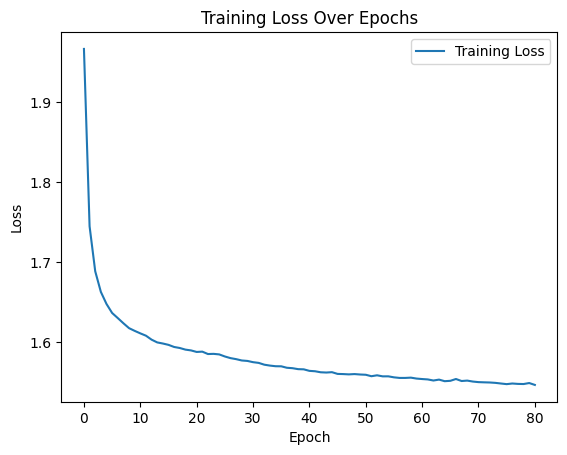

In [12]:
import matplotlib.pyplot as plt
# Plot the training loss values
plt.plot(train_loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

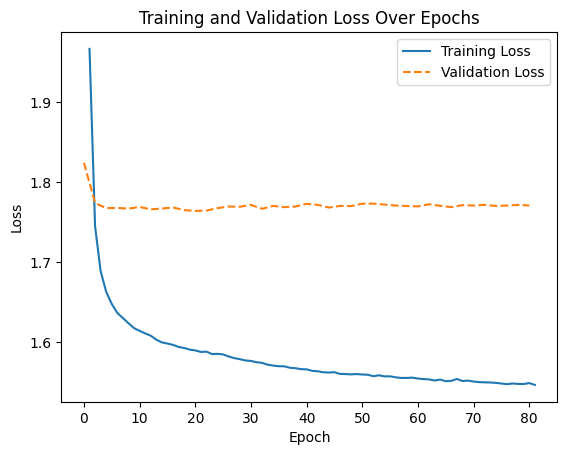

In [13]:
# Plot the training and validation loss values
epochs = range(1, len(train_loss_values) + 1)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(range(0, len(validation_loss_values) * validate_every, validate_every), validation_loss_values, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

### Test the best model on train, validation and test sets

In [14]:
def predict_label(predictions):
  """
  Converts a 10-dimensional probability vector to the class label (index of max probability).
  Args:
      predictions: A torch.Tensor of size (batch_size, 10) containing probability predictions.
  Returns:
      A torch.Tensor of size (batch_size) containing the predicted class labels (integers).
  """
  # Get the index of the maximum probability along the dimension with 10 elements (classes)
  _, predicted_labels = torch.max(predictions, dim=1)
  return predicted_labels
    
# Example usage
# predict_y_int = predict_label(predict_y)

In [15]:
import audmetric

# Test the model
# Load the best model for testing
#best_model = ConvGRUModel(input_size, hidden_size, num_layers, num_classes, dropout_prob)
#best_model = SimpleMLP(input_size, hidden_size, num_classes, dropout_prob, l2_reg)
best_model = SimpleMLP(input_size, hidden_size1, hidden_size2, num_classes, dropout_prob, l2_reg)

best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

# Training set
with torch.no_grad():
    test_outputs = best_model(X_train.to(device))
    test_loss    = criterion(test_outputs, y_train.to(torch.int64).to(device))
print(f'Train Loss: {test_loss.item():.4f}')
print("Accuracy on Training set = " + str(audmetric.accuracy(df_train_lab['label'], predict_label(test_outputs.cpu()))))

# Validation set
with torch.no_grad():
    test_outputs = best_model(X_test.to(device))
    test_loss    = criterion(test_outputs, y_test.to(torch.int64).to(device))
print(f'Validation Loss: {test_loss.item():.4f}')
print("Accuracy on Validation set = " + str(audmetric.accuracy(df_valid_lab['label'], predict_label(test_outputs.cpu()))))

Train Loss: 1.5318
Accuracy on Training set = 0.9290531885937525
Validation Loss: 1.7641
Accuracy on Validation set = 0.6956883715717511


### Load Test Set 

In [16]:
features3 = df_test_feat.values.astype(np.float32)
labels3   = df_test_lab['label'].values.astype(np.float32)

# Normalize the features between -1 and 1 (adjust scaling based on your data)
# features = (features - np.min(features)) / (np.max(features) - np.min(features)) * 2 - 1

# features3 = (features3 - np.min(features)) / (np.max(features) - np.min(features))

# Convert data to PyTorch tensors
features_tensor3 = torch.from_numpy(features3)
labels_tensor3   = torch.from_numpy(labels3)

# Assuming you want a sequence length of 1
# features_tensor = features_tensor.unsqueeze(1)

######
# Reshape features tensor with sequence length of 50
sequence_length3 = 1
num_features3    = features3.shape[1]
num_samples3     = features3.shape[0]

# Calculate the number of sequences that can be formed
num_sequences3 = num_samples3 // sequence_length3

# Truncate the tensor to fit the full sequences
features_tensor3 = features_tensor3[:num_sequences3 * sequence_length3, :]
labels_tensor3   = labels_tensor3[:num_sequences3 * sequence_length3]

# Reshape the tensor
features_tensor3 = features_tensor3.view(num_sequences3, sequence_length3, num_features3)

In [17]:
# Test the model
# Load the best model for testing
#best_model = ConvGRUModel(input_size, hidden_size, num_layers, num_classes, dropout_prob)
#best_model = SimpleMLP(input_size, hidden_size, num_classes, dropout_prob, l2_reg)
best_model = SimpleMLP(input_size, hidden_size1, hidden_size2, num_classes, dropout_prob, l2_reg)

best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

# Test set
with torch.no_grad():
    test_outputs = best_model(features_tensor3.to(device))
    test_loss    = criterion(test_outputs, labels_tensor3.to(torch.int64).to(device))
print(f'Test Loss: {test_loss.item():.4f}')
print("Accuracy on Test set = " + str(audmetric.accuracy(df_test_lab['label'], predict_label(test_outputs.cpu()))))

Test Loss: 1.7715
Accuracy on Test set = 0.6878510976697592


### Aggregation of Predictions for each track (wav)

In [18]:
df_test_lab['pred'] = predict_label(test_outputs.cpu())

df_test_probs = pd.DataFrame(test_outputs.cpu())

cols = df_test_lab.columns.to_list() + df_test_probs.columns.to_list()
dft = [df_test_lab, df_test_probs]
df_test_pred = np.concatenate(dft, axis=1)
df_test_pred = pd.DataFrame(df_test_pred, columns=cols)

# df_test_lab.shape, df_test_probs.shape, df_test_pred.shape

# Group by 'genre' and 'track_number', then calculate the average of each column 0 to 9
average_values = df_test_pred.groupby(['genre', 'track_number', 'label'])[list(range(10))].mean().reset_index()

average_values['max_value_column'] = average_values.iloc[:, 3:].idxmax(axis=1)

print("Accuracy on Test set = " + str(100*audmetric.accuracy(average_values['label'], average_values['max_value_column'])) + " %")

Accuracy on Test set = 76.34730538922156 %


In [19]:
print(f'Test Loss: {test_loss.item():.4f}')
print("Accuracy on Test set = " + str(audmetric.accuracy(df_test_lab['label'], predict_label(test_outputs.cpu()))))
print("Accuracy on Test set = " + str(100*audmetric.accuracy(average_values['label'], average_values['max_value_column'])) + " %")

Test Loss: 1.7715
Accuracy on Test set = 0.6878510976697592
Accuracy on Test set = 76.34730538922156 %
